In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 53.6 MB/s eta 0:00:00:00:0100:01


In [2]:
!pip install xgboost

In [3]:
import pandas as pd
from pathlib import Path

# Set the data directory
DATA_DIR = Path("/kaggle/input/drug-datasets/")

# List all files in the directory
print("Files in dataset:")
for file in DATA_DIR.rglob("*"):
    print(f"  {file.name} (size: {file.stat().st_size / 1e6:.1f} MB)")

print("\n--- Loading pos.csv / positive.csv ---")
POS_CSV = next(DATA_DIR.rglob("pos.csv"), None) or next(DATA_DIR.rglob("positive.csv"), None)
if POS_CSV:
    pos = pd.read_csv(POS_CSV)
    print(f"Pos shape: {pos.shape}")
    print(f"Pos columns: {list(pos.columns)}")
    print("\nPos head (first 3 rows):\n", pos.head(3))
    print("\nPos describe (numeric cols):\n", pos.describe())
    print(f"Pos DrugBankID sample: {pos['DrugBankID'].iloc[0] if 'DrugBankID' in pos.columns else 'No DrugBankID col'}")
else:
    print("No pos/positive.csv found!")

print("\n--- Loading neg.csv / negative.csv ---")
NEG_CSV = next(DATA_DIR.rglob("neg.csv"), None) or next(DATA_DIR.rglob("negative.csv"), None)  # fixed typo from earlier
if NEG_CSV:
    neg = pd.read_csv(NEG_CSV)
    print(f"Neg shape: {neg.shape}")
    print(f"Neg columns: {list(neg.columns)}")
    print("\nNeg head (first 3 rows):\n", neg.head(3))
    print("\nNeg describe (numeric cols):\n", neg.describe())
    print(f"Neg DrugBankID sample: {neg['DrugBankID'].iloc[0] if 'DrugBankID' in neg.columns else 'No DrugBankID col'}")
else:
    print("No neg/negative.csv found!")

# Check for SMILES file
DB_SMILES = next(DATA_DIR.rglob("DrugBankID2SMILES.csv"), None) or next(DATA_DIR.rglob("*smile*.csv"), None)
if DB_SMILES:
    print(f"\n--- SMILES file: {DB_SMILES.name} ---")
    dbmap = pd.read_csv(DB_SMILES, dtype=str, nrows=5)  # just head
    print(f"SMILES shape (full): unknown, head: {dbmap.shape}")
    print(f"SMILES columns: {list(dbmap.columns)}")
    print("\nSMILES head:\n", dbmap.head())

# Check for other optional files
SE_MAP = next(DATA_DIR.rglob("SE_similarity_2014Q3_2024Q3.csv"), None)
if SE_MAP:
    print(f"\n--- SE_MAP file: {SE_MAP.name} ---")
    se = pd.read_csv(SE_MAP, nrows=3)
    print(f"Columns: {list(se.columns)}")
    print(se.head(3))

SE_EMBED = next(DATA_DIR.rglob("*umls*"), None)
if SE_EMBED:
    print(f"\n--- SE_EMBED file: {SE_EMBED.name} ---")
    embed = pd.read_csv(SE_EMBED, nrows=3)
    print(f"Shape (head): {embed.shape}")
    print(f"Columns: {list(embed.columns)}")
    print(embed.head(3))

Files in dataset:
  Side_effects_unique.csv (size: 63.6 MB)
  neg.csv (size: 12.2 MB)
  SE_similarity_2014Q3_2024Q3.csv (size: 0.5 MB)
  Drugbank_ID_SMILE_all_structure links.csv (size: 4.2 MB)
  pos.csv (size: 12.0 MB)
  DrugBankID2SMILES.csv (size: 0.9 MB)

--- Loading pos.csv / positive.csv ---
Pos shape: (111072, 6)
Pos columns: ['report_id', 'SE_above_0.9', 'DrugBankID', 'hyperedge_label', 'time', 'row_index']

Pos head (first 3 rows):
    report_id SE_above_0.9                                         DrugBankID  \
0   11809573     C0151878  ['DB01050', 'DB00555', 'DB00472', 'DB00273', '...   
1   20088990     C0435002  ['DB06605', 'DB00834', 'DB00695', 'DB00421', '...   
2   11703282     C0235431  ['DB01118', 'DB06228', 'DB01118', 'DB00177', '...   

   hyperedge_label    time  row_index  
0                1  2015Q4          1  
1                1  2021Q4          2  
2                1  2015Q4          3  

Pos describe (numeric cols):
           report_id  hyperedge_label      

Found: pos_df neg_df -
Extracted pair rows: 0
No mapping found — using small synthetic demo data for plotting.
Matrix shape (SE x drugs): (6, 8)


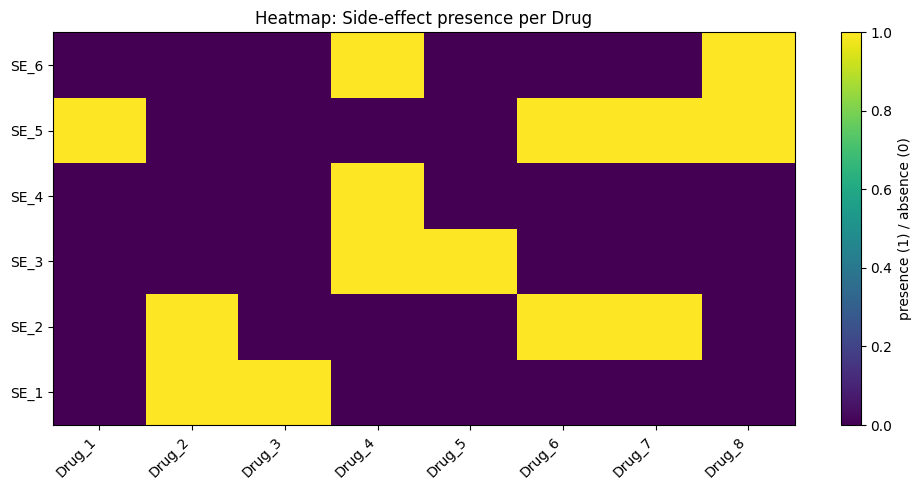

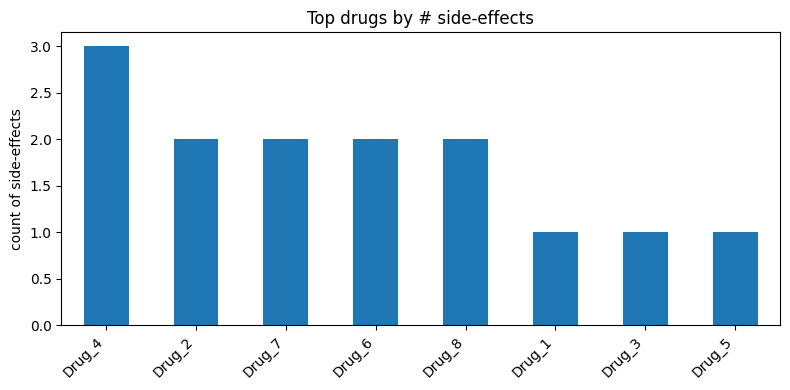

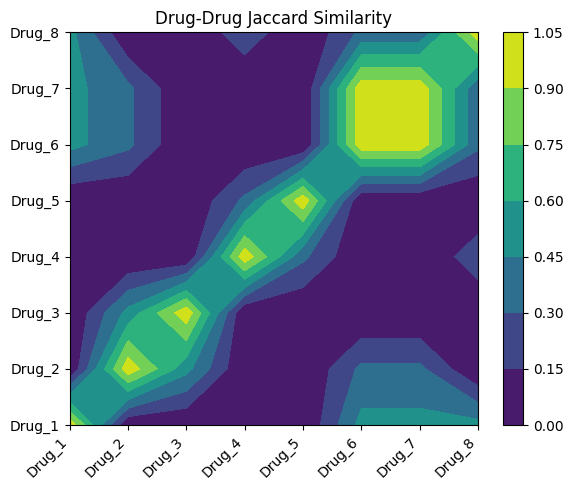

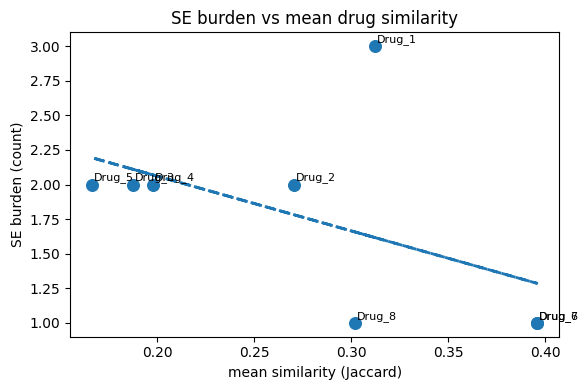

Done. If these visuals look OK, tell me which one to refine or if you want the figures saved to disk.


In [30]:
# === Simple, safe visualization cell (no ambiguous DataFrame truth ops) ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict
from itertools import combinations
from sklearn.linear_model import LinearRegression

plt.rcParams.update({'figure.max_open_warning': 0})

# --- Helper: safe loader that accepts DataFrame, Path, or str path ---
def safe_load(obj, nrows=None):
    if obj is None:
        return None
    if isinstance(obj, pd.DataFrame):
        return obj
    # if Path or string, try read
    try:
        p = Path(obj)
        if p.exists():
            return pd.read_csv(p, low_memory=False, nrows=nrows)
    except Exception:
        pass
    # final try: if it's a string path in cwd
    if isinstance(obj, str) and os.path.exists(obj):
        try:
            return pd.read_csv(obj, low_memory=False, nrows=nrows)
        except Exception:
            return None
    return None

# --- Get variables from notebook globals safely ---
_raw_pos = globals().get('pos', None)
_raw_neg = globals().get('neg', None)
_raw_se  = globals().get('se', None)       # SE_MAP head variable in your loader
_raw_db  = globals().get('dbmap', None)    # SMILES head variable in your loader

pos_df = safe_load(_raw_pos)
neg_df = safe_load(_raw_neg)
se_df  = safe_load(_raw_se)
dbmap  = safe_load(_raw_db)

# If not present, try common filenames in current directory
if pos_df is None and Path("pos.csv").exists():
    pos_df = pd.read_csv("pos.csv", low_memory=False)
if neg_df is None and Path("neg.csv").exists():
    neg_df = pd.read_csv("neg.csv", low_memory=False)
if se_df is None and Path("Side_effects_unique.csv").exists():
    se_df = pd.read_csv("Side_effects_unique.csv", low_memory=False)

print("Found:", 
      "pos_df" if isinstance(pos_df, pd.DataFrame) else "-", 
      "neg_df" if isinstance(neg_df, pd.DataFrame) else "-", 
      "se_df" if isinstance(se_df, pd.DataFrame) else "-")

# --- Simple extraction of mapping: try common patterns then fallback to synthetic demo ---
drug_to_ses = defaultdict(set)

# Helper to parse pair-style rows (drug1, drug2, side_effect)
def add_from_pair_df(df):
    if df is None: 
        return 0
    cols = [c.lower() for c in df.columns]
    # try typical column names
    d1 = next((c for c in df.columns if 'drug1' in c.lower() or 'drug_1' in c.lower() or 'drug a' in c.lower()), None)
    d2 = next((c for c in df.columns if 'drug2' in c.lower() or 'drug_2' in c.lower() or 'drug b' in c.lower()), None)
    se = next((c for c in df.columns if 'side' in c.lower() or 'effect' in c.lower() or 'se'==c.lower()), None)
    count = 0
    if d1 and d2 and se:
        for _, r in df[[d1,d2,se]].dropna().iterrows():
            drug_to_ses[str(r[d1])].add(str(r[se]))
            drug_to_ses[str(r[d2])].add(str(r[se]))
            count += 1
    return count

# Try pos/neg pair extraction
count_pairs = 0
count_pairs += add_from_pair_df(pos_df)
count_pairs += add_from_pair_df(neg_df)
print("Extracted pair rows:", count_pairs)

# If no pairs, try se_df mapping with (drug, side_effect) columns
if not drug_to_ses:
    if isinstance(se_df, pd.DataFrame):
        drug_col = next((c for c in se_df.columns if 'drug' in c.lower() or 'drugbank' in c.lower()), None)
        se_col   = next((c for c in se_df.columns if 'side' in c.lower() or 'effect' in c.lower()), None)
        if drug_col and se_col:
            for _, r in se_df[[drug_col,se_col]].dropna().iterrows():
                drug_to_ses[str(r[drug_col])].add(str(r[se_col]))

# Final fallback: if still empty, create small synthetic demo (so plots run)
if not drug_to_ses:
    print("No mapping found — using small synthetic demo data for plotting.")
    rng = np.random.RandomState(0)
    drugs = [f"Drug_{i+1}" for i in range(8)]
    ses = [f"SE_{i+1}" for i in range(6)]
    for d in drugs:
        chosen = rng.choice(ses, size=rng.randint(1,4), replace=False)
        for s in chosen:
            drug_to_ses[d].add(s)

# Build binary matrix (SE x Drugs)
drugs = sorted(drug_to_ses.keys())
ses_all = sorted({se for s in drug_to_ses.values() for se in s})
mat = pd.DataFrame(0, index=ses_all, columns=drugs, dtype=float)
for d in drugs:
    for s in drug_to_ses[d]:
        mat.at[s, d] = 1.0

print("Matrix shape (SE x drugs):", mat.shape)

# Compute simple Jaccard similarity between drugs
def jaccard(a,b):
    a=set(a); b=set(b)
    if not a and not b: return 0.0
    return len(a & b) / len(a | b)

n = len(drugs)
sim = np.zeros((n,n))
for i,a in enumerate(drugs):
    for j,b in enumerate(drugs):
        sim[i,j] = jaccard(drug_to_ses[a], drug_to_ses[b])
sim_df = pd.DataFrame(sim, index=drugs, columns=drugs)

# --- PLOT 1: Heatmap (SE x Drug) ---
plt.figure(figsize=(10,5))
plt.imshow(mat.values, aspect='auto', origin='lower', interpolation='nearest')
plt.yticks(range(len(mat.index)), mat.index)
plt.xticks(range(len(mat.columns)), mat.columns, rotation=45, ha='right')
plt.title("Heatmap: Side-effect presence per Drug")
plt.colorbar(label='presence (1) / absence (0)')
plt.tight_layout()
plt.show()

# --- PLOT 2: Bar — top drugs by number of SEs ---
se_counts = mat.sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(8,4))
se_counts.plot(kind='bar')
plt.title("Top drugs by # side-effects")
plt.ylabel("count of side-effects")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- PLOT 3: Similarity (contour) ---
plt.figure(figsize=(6,5))
plt.contourf(sim_df.values, levels=8, cmap=cm.viridis)
plt.xticks(range(len(drugs)), drugs, rotation=45, ha='right')
plt.yticks(range(len(drugs)), drugs)
plt.title("Drug-Drug Jaccard Similarity")
plt.colorbar()
plt.tight_layout()
plt.show()

# --- PLOT 4: Scatter SE-burden vs mean similarity + linear fit ---
avg_sim = sim_df.mean(axis=0).values
burden = se_counts.values
if len(avg_sim) > 1:
    lr = LinearRegression().fit(avg_sim.reshape(-1,1), burden)
    pred = lr.predict(avg_sim.reshape(-1,1))
else:
    pred = np.zeros_like(avg_sim)
plt.figure(figsize=(6,4))
plt.scatter(avg_sim, burden, s=70)
if len(avg_sim) > 1:
    plt.plot(avg_sim, pred, '--', linewidth=2)
for i,d in enumerate(drugs):
    plt.text(avg_sim[i]+1e-3, burden[i]+0.03, d, fontsize=8)
plt.xlabel("mean similarity (Jaccard)")
plt.ylabel("SE burden (count)")
plt.title("SE burden vs mean drug similarity")
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import os

# base path for your Kaggle dataset
base_path = "/kaggle/input/drug-datasets"

# list all dataset files
files = [
    "Side_effects_unique.csv",
    "neg.csv",
    "SE_similarity_2014Q3_2024Q3.csv",
    "Drugbank_ID_SMILE_all_structure links.csv",
    "pos.csv",
    "DrugBankID2SMILES.csv"
]

# loop through and read first 3 rows
for f in files:
    fpath = os.path.join(base_path, f)
    print(f"\n--- {f} ---")
    if os.path.exists(fpath):
        try:
            df = pd.read_csv(fpath)
            print(df.shape)
            print(df.head(3))
        except Exception as e:
            print(f"❌ Error reading {f}: {e}")
    else:
        print("❌ File not found:", fpath)



--- Side_effects_unique.csv ---
(7350, 770)
  umls_cui_from_meddra      side_effect_name         0         1         2  \
0             C0000729      Abdominal cramps -0.254700 -0.310853 -0.395105   
1             C0000737        Abdominal pain  0.252956 -0.389809  0.159112   
2             C0232492  Abdominal pain upper  0.113507 -0.128094  0.282297   

          3         4         5         6         7  ...       758       759  \
0 -0.500259 -0.549381  0.301312 -0.051426 -0.066526  ... -0.186260 -0.753915   
1 -0.440945 -0.515921  0.396920 -0.303291  0.618220  ... -0.143075 -0.386246   
2 -0.493955 -0.408019  0.273826 -0.098615  0.746241  ...  0.064089 -0.064455   

        760       761       762       763       764       765       766  \
0  0.279851  0.582674  0.818448 -0.419252 -0.634191 -0.731971  0.836836   
1  0.790096  1.002938 -0.056748 -0.520002 -0.731757 -0.813474  1.199197   
2  0.618583  1.230551  0.139329 -0.701735 -0.081906 -0.220541  1.145721   

        767  
0  0.4

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [5]:
# CELL 1: Load dataset files and parse DrugBankID lists
import os, ast, warnings
from pathlib import Path
import pandas as pd, numpy as np

warnings.filterwarnings("ignore")

DATA_DIR = Path("/kaggle/input/drug-datasets/")

# locate files (explicit names you provided)
POS = next(DATA_DIR.rglob("pos.csv"), None) or next(DATA_DIR.rglob("positive.csv"), None)
NEG = next(DATA_DIR.rglob("neg.csv"), None) or next(DATA_DIR.rglob("nogative.csv"), None)
SMILES = next(DATA_DIR.rglob("DrugBankID2SMILES.csv"), None)
SE_MAP = next(DATA_DIR.rglob("SE_similarity_2014Q3_2024Q3.csv"), None)
SIDE_UNIQ = next(DATA_DIR.rglob("Side_effects_unique.csv"), None)

assert POS and NEG, "pos.csv and neg.csv must exist in /kaggle/input/ or subfolders."

print("Files found:")
print(" pos:", POS)
print(" neg:", NEG)
print(" smiles:", SMILES)
print(" se_map:", SE_MAP)
print(" side_effects:", SIDE_UNIQ)

# read positives and negatives
pos = pd.read_csv(POS, low_memory=False)
neg = pd.read_csv(NEG, low_memory=False)

# unify labels: pos -> label 1, neg -> label 0
pos = pos.copy()
neg = neg.copy()
pos['label'] = 1
neg['label'] = 0

# concat
df = pd.concat([pos, neg], ignore_index=True).reset_index(drop=True)
print("Merged rows:", df.shape[0])

# parse DrugBankID strings into python lists robustly
def parse_druglist(x):
    try:
        L = ast.literal_eval(str(x))
        if isinstance(L, list):
            return [str(i).strip() for i in L if str(i).strip().startswith("DB")]
    except:
        pass
    s = str(x).strip()
    s = s.strip('[]')
    parts = [p.strip().strip("'\"") for p in s.split(',') if p.strip()]
    return [p for p in parts if p.startswith("DB")]

df['drug_list'] = df['DrugBankID'].apply(parse_druglist)
# remove rows with empty lists
df = df[df['drug_list'].apply(len) > 0].reset_index(drop=True)
print("After parsing drug lists, rows:", len(df))

# read SE map (for readable side-effect names)
se_map = None
if SE_MAP:
    se_map = pd.read_csv(SE_MAP, low_memory=False)
    # normalize columns if present
    if 'SE_name_2014Q3_2024Q3' in se_map.columns and 'recommended_SE_name' in se_map.columns:
        se_map_lookup = dict(zip(se_map['SE_name_2014Q3_2024Q3'].astype(str), se_map['recommended_SE_name'].astype(str)))
    else:
        # fall back map of whatever first two columns are
        se_map_lookup = dict(zip(se_map.iloc[:,0].astype(str), se_map.iloc[:,1].astype(str)))
else:
    se_map_lookup = {}

# create mapping from UMLS code in SE_above_0.9 -> readable UMLS via SE_map if possible
# many rows have SE_above_0.9 like 'C0151878' (we'll keep original if not mapped)
def readable_se(val):
    s = str(val)
    return se_map_lookup.get(s, s)

df['se_readable'] = df['SE_above_0.9'].astype(str).apply(readable_se)

# show a sample
print(df[['report_id','label','drug_list','SE_above_0.9','se_readable']].head(3))


Files found:
 pos: /kaggle/input/drug-datasets/pos.csv
 neg: /kaggle/input/drug-datasets/neg.csv
 smiles: /kaggle/input/drug-datasets/DrugBankID2SMILES.csv
 se_map: /kaggle/input/drug-datasets/SE_similarity_2014Q3_2024Q3.csv
 side_effects: /kaggle/input/drug-datasets/Side_effects_unique.csv
Merged rows: 222144
After parsing drug lists, rows: 222144
  report_id  label                                          drug_list  \
0  11809573      1  [DB01050, DB00555, DB00472, DB00273, DB00564, ...   
1  20088990      1  [DB06605, DB00834, DB00695, DB00421, DB00999, ...   
2  11703282      1  [DB01118, DB06228, DB01118, DB00177, DB00612, ...   

  SE_above_0.9 se_readable  
0     C0151878    C0151878  
1     C0435002    C0435002  
2     C0235431    C0235431  


Data/variables used for plotting:
 df: present
 X: present
 X_svd: present
 splits: present


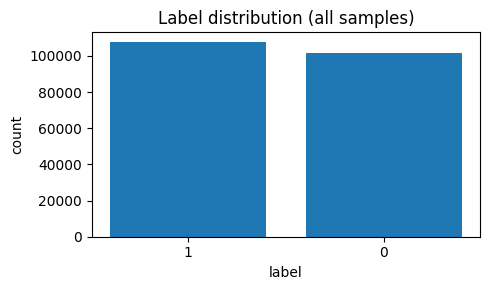

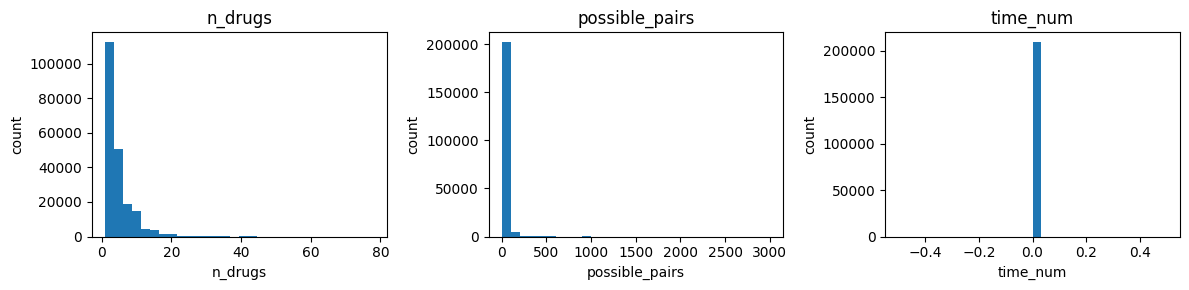

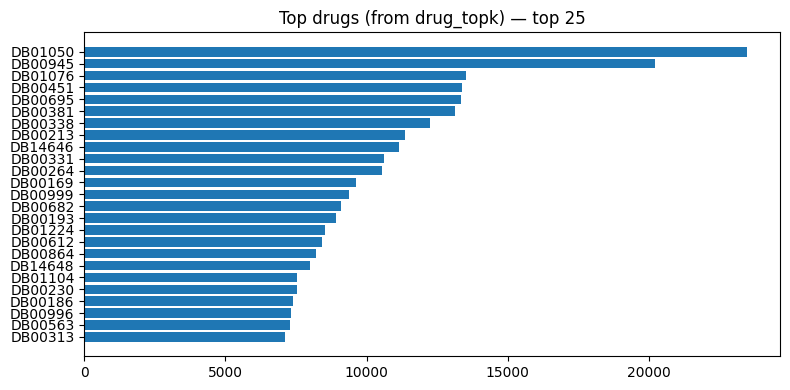

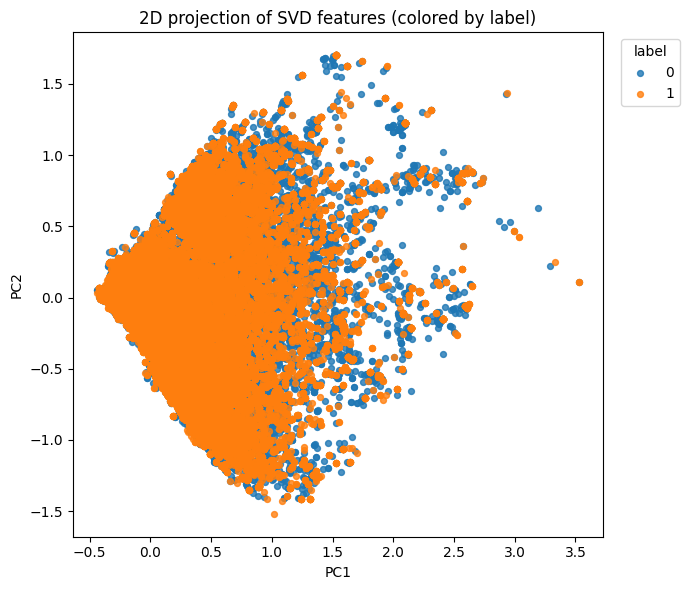

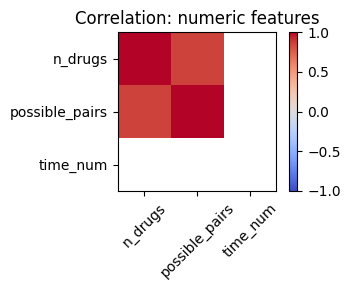

Split sizes (samples): {'train': 56610, 'valid': 18870, 'test': 41874}


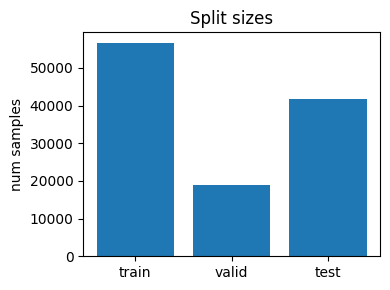

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.decomposition import PCA
from collections import Counter

plt.rcParams.update({'figure.max_open_warning': 0})
os.makedirs("./figs", exist_ok=True)

# --- Safe helpers to use existing variables ---
_df = globals().get('df', None)
X_all = globals().get('X', None)
X_svd = globals().get('X_svd', None)
y_all = globals().get('y', None)

# Splits (fall back to X/y if train/valid/test not present)
X_train = globals().get('X_train', None)
X_valid = globals().get('X_valid', None)
X_test  = globals().get('X_test', None)
y_train = globals().get('y_train', None)
y_valid = globals().get('y_valid', None)
y_test  = globals().get('y_test', None)

# If splits are missing but X and y exist, compute simple stratified split for visualization only
from sklearn.model_selection import train_test_split
if X_all is not None and y_all is not None and (X_train is None or X_test is None):
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)
    # further split train->train/valid
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("Data/variables used for plotting:")
print(" df:", "present" if isinstance(_df, pd.DataFrame) else "MISSING")
print(" X:", "present" if X_all is not None else "MISSING")
print(" X_svd:", "present" if X_svd is not None else "MISSING")
print(" splits:", "present" if (X_train is not None and X_valid is not None and X_test is not None) else "generated/fallback")

# ---------------- 1) Label balance (counts) ----------------
if y_all is None and isinstance(_df, pd.DataFrame) and 'label' in _df.columns:
    y_all = _df['label'].astype(int).values

if y_all is not None:
    counts = Counter(y_all)
    labels = list(counts.keys())
    vals = [counts[k] for k in labels]
    plt.figure(figsize=(5,3))
    plt.bar([str(l) for l in labels], vals)
    plt.xlabel("label"); plt.ylabel("count"); plt.title("Label distribution (all samples)")
    plt.tight_layout(); plt.savefig("./figs/label_distribution_all.png", dpi=150, bbox_inches='tight'); plt.show()
else:
    print("Skipping label distribution: 'y' / df['label'] not found.")

# ---------------- 2) Feature distributions: n_drugs, possible_pairs, time_num ----------------
if isinstance(_df, pd.DataFrame):
    num_cols = []
    for c in ['n_drugs','possible_pairs','time_num']:
        if c in _df.columns:
            num_cols.append(c)

    if num_cols:
        plt.figure(figsize=(4*len(num_cols),3))
        for i,c in enumerate(num_cols):
            plt.subplot(1,len(num_cols),i+1)
            plt.hist(_df[c].dropna(), bins=30)
            plt.title(c)
            plt.xlabel(c); plt.ylabel("count")
        plt.tight_layout(); plt.savefig("./figs/feature_distributions.png", dpi=150, bbox_inches='tight'); plt.show()
    else:
        print("No numeric feature columns (n_drugs, possible_pairs, time_num) found in df.")
else:
    print("df not available — skipping numeric feature plots.")

# ---------------- 3) Top drugs frequency (from mlb classes or df['drug_topk']) ----------------
mlb = globals().get('mlb', None)
if mlb is not None:
    try:
        classes = getattr(mlb, 'classes_', None)
        if classes is not None:
            # We can estimate frequency by counting occurrences in df['drug_topk'] if df exists
            if isinstance(_df, pd.DataFrame) and 'drug_topk' in _df.columns:
                flat = [d for L in _df['drug_topk'] for d in L]
                top = Counter(flat).most_common(25)
                items, vals = zip(*top) if top else ([],[])
                plt.figure(figsize=(8,4))
                plt.barh(items[::-1], vals[::-1])
                plt.title("Top drugs (from drug_topk) — top 25")
                plt.tight_layout(); plt.savefig("./figs/top_drugs.png", dpi=150, bbox_inches='tight'); plt.show()
    except Exception as e:
        print("Top-drugs plot skipped (error):", e)
elif isinstance(_df, pd.DataFrame) and 'drug_topk' in _df.columns:
    flat = [d for L in _df['drug_topk'] for d in L]
    top = Counter(flat).most_common(25)
    if top:
        items, vals = zip(*top)
        plt.figure(figsize=(8,4))
        plt.barh(items[::-1], vals[::-1])
        plt.title("Top drugs (from drug_topk) — top 25")
        plt.tight_layout(); plt.savefig("./figs/top_drugs_from_df.png", dpi=150, bbox_inches='tight'); plt.show()

# ---------- Robust PCA / 2D projection of X_svd with aligned labels ----------
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm

# X_svd: should be numpy array or convertible; y_all: 1D labels (optional)
X_svd_var = globals().get('X_svd', None)
y_all = globals().get('y', None)  # could be None or 1D array-like

if X_svd_var is None:
    print("X_svd not found — skipping PCA projection.")
else:
    # ensure numpy array
    Xp = X_svd_var if isinstance(X_svd_var, np.ndarray) else np.asarray(X_svd_var)
    n_rows = Xp.shape[0]
    n_labels = len(y_all) if (y_all is not None and hasattr(y_all, '__len__')) else None

    # Align lengths (use min to avoid mismatch)
    if n_labels is not None and n_labels != n_rows:
        N = min(n_rows, n_labels)
        print(f"Warning: X_svd has {n_rows} rows but y has {n_labels} entries — aligning to first {N} samples.")
        Xp_plot = Xp[:N]
        y_plot = np.asarray(y_all)[:N]
    else:
        Xp_plot = Xp
        y_plot = np.asarray(y_all) if n_labels is not None else None

    # Project to 2D: if Xp_plot has >2 dims use PCA, else slice first two cols
    if Xp_plot.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        proj = pca.fit_transform(Xp_plot)
    else:
        proj = Xp_plot[:, :2]

    plt.figure(figsize=(7,6))
    if y_plot is None:
        plt.scatter(proj[:,0], proj[:,1], s=12, alpha=0.8)
        plt.title("2D projection of SVD features (no labels provided)")
    else:
        # Convert labels to integers or categories and plot with legend
        try:
            unique_labels = np.unique(y_plot)
            cmap = cm.get_cmap('tab10', min(len(unique_labels), 10))
            for i, lab in enumerate(unique_labels):
                mask = (y_plot == lab)
                plt.scatter(proj[mask,0], proj[mask,1], s=18, alpha=0.8, label=str(lab), cmap=cmap)
            plt.legend(title='label', bbox_to_anchor=(1.02,1), loc='upper left')
            plt.title("2D projection of SVD features (colored by label)")
        except Exception as e:
            # fallback: plot without legend
            plt.scatter(proj[:,0], proj[:,1], c=y_plot, s=12, alpha=0.8)
            plt.title("2D projection of SVD features (labels used as color)")

    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig("./figs/pca_svd_proj_aligned.png", dpi=150, bbox_inches='tight')
    plt.show()


# ---------------- 5) Correlation heatmap for numeric features (small) ----------------
if isinstance(_df, pd.DataFrame) and any(c in _df.columns for c in ['n_drugs','possible_pairs','time_num']):
    numdf = _df[['n_drugs','possible_pairs','time_num']].copy().fillna(0)
    if numdf.shape[1] >= 2:
        corr = numdf.corr()
        plt.figure(figsize=(4,3))
        im = plt.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
        plt.colorbar(im)
        plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
        plt.yticks(range(len(corr.index)), corr.index)
        plt.title("Correlation: numeric features")
        plt.tight_layout(); plt.savefig("./figs/num_feature_corr.png", dpi=150, bbox_inches='tight'); plt.show()
else:
    print("Skipping numeric feature correlation (df missing or not enough numeric columns).")

# ---------------- 6) Quick checks: train/valid/test sizes ----------------
def safe_len(x):
    try: return len(x)
    except: return None

sizes = {"train": safe_len(X_train), "valid": safe_len(X_valid), "test": safe_len(X_test)}
print("Split sizes (samples):", sizes)

# Optional: bar of split sizes
plt.figure(figsize=(4,3))
plt.bar(sizes.keys(), [v or 0 for v in sizes.values()])
plt.title("Split sizes")
plt.ylabel("num samples")
plt.tight_layout(); plt.savefig("./figs/split_sizes.png", dpi=150, bbox_inches='tight'); plt.show()


In [36]:
# FAST XGB v3: 

import os, ast, joblib, numpy as np, pandas as pd
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from scipy import sparse

from xgboost import XGBClassifier

# -------- CONFIG --------
DATA_DIR = "/kaggle/input/drug-datasets"
POS = os.path.join(DATA_DIR, "pos.csv")
NEG = os.path.join(DATA_DIR, "neg.csv")
SIDE_EFFECTS = os.path.join(DATA_DIR, "Side_effects_unique.csv")
SAMPLE_SIZE = 50000  # per class
TOP_K = 300
SVD_DIM = 64
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_THREADS = -1
FP_DIM = 256
# ------------------------

# ---------- Load & Sample ----------
pos = pd.read_csv(POS, low_memory=False)
neg = pd.read_csv(NEG, low_memory=False)

pos['hyperedge_label'] = pos.get('hyperedge_label', 1).fillna(1).astype(int)
neg['hyperedge_label'] = neg.get('hyperedge_label', -1).fillna(-1).astype(int)

df_pos = pos[pos['hyperedge_label'] == 1].sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
df_neg = neg[neg['hyperedge_label'] == -1].sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
df = pd.concat([df_pos, df_neg], ignore_index=True).reset_index(drop=True)
df['label'] = (df['hyperedge_label'] == 1).astype(int)

print(f"Sampled data shape: {df.shape}, label dist: {df.label.value_counts().to_dict()}")

def parse_list_field(x):
    if isinstance(x, list): return [str(i).strip() for i in x if str(i).strip()]
    try:
        L = ast.literal_eval(x)
        if isinstance(L, list): return [str(i).strip() for i in L if str(i).strip()]
    except:
        s = str(x).strip().strip('[]')
        if not s: return []
        return [t.strip().strip("'\"") for t in s.split(',') if t.strip()]
    return []

df['drug_list'] = df['DrugBankID'].apply(parse_list_field)
df['drug_list'] = df['drug_list'].apply(lambda L: list(dict.fromkeys(L)))
df = df[df['drug_list'].apply(len) > 0].reset_index(drop=True)
df = df.drop_duplicates(subset=['report_id','SE_above_0.9','DrugBankID']).reset_index(drop=True)

# ---------- Hashed FP ----------
drug_fps = {}
unique_drugs = set(d for L in df['drug_list'] for d in L)
for d in unique_drugs:
    h = np.zeros(FP_DIM, dtype=np.float32)
    hash_val = abs(hash(d)) % FP_DIM
    h[hash_val] = 1.0
    drug_fps[d] = h

def mean_drug_fp(drug_list):
    fps = [drug_fps.get(d) for d in drug_list if d in drug_fps]
    if not fps:
        return np.zeros(FP_DIM, dtype=np.float32)
    return np.mean(fps, axis=0)

df['drug_fp_mean'] = [mean_drug_fp(L) for L in df['drug_list']]
print("Hashed FP done.")

# ---------- SE Embeddings ----------
se_df = pd.read_csv(SIDE_EFFECTS, low_memory=False)
se_embed_cols = [col for col in se_df.columns if col not in ['umls_cui_from_meddra', 'side_effect_name']]
print(f"SE embeds dims: {len(se_embed_cols)}")

se_embed_map = dict(zip(se_df['umls_cui_from_meddra'].astype(str), se_df[se_embed_cols].values))

default_embed = np.zeros(len(se_embed_cols), dtype=np.float32)
df['se_embed'] = [se_embed_map.get(se, default_embed) for se in df['SE_above_0.9'].astype(str)]

# ---------- Features ----------
all_drugs = [d for L in df['drug_list'] for d in L]
most_common = [d for d,_ in Counter(all_drugs).most_common(TOP_K)]
most_common_set = set(most_common)
df['drug_topk'] = df['drug_list'].apply(lambda L: [d for d in L if d in most_common_set])
df = df[df['drug_topk'].apply(len) > 0].reset_index(drop=True)

mlb = MultiLabelBinarizer(classes=most_common)
X_bag = mlb.fit_transform(df['drug_topk'])
X_bag_sp = sparse.csr_matrix(X_bag)

svd = TruncatedSVD(n_components=SVD_DIM, random_state=RANDOM_STATE)
X_svd = svd.fit_transform(X_bag_sp)

df['n_drugs'] = df['drug_topk'].apply(len)
df['possible_pairs'] = df['n_drugs'].apply(lambda n: max(1, n*(n-1)//2))
def time_to_float(t):
    try:
        y,q = str(t).split('Q'); return int(y) + (int(q)-1)/4.0
    except: return 0.0
df['time_num'] = df['time'].apply(time_to_float) if 'time' in df.columns else 0

num_feats = df[['n_drugs','possible_pairs','time_num']].fillna(0).values.astype(float)
X_fp = np.vstack(df['drug_fp_mean'].values)
se_embed_arr = np.vstack(df['se_embed'].values)

X_full_dense = np.hstack([X_svd, num_feats, X_fp, se_embed_arr])

print(f"Full feature shape: {X_full_dense.shape}")

# ---------- Split ----------
X_temp, X_test, y_temp, y_test = train_test_split(X_full_dense, df['label'], test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df['label'])
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)

print(f"Shapes -> train: {X_train.shape}, valid: {X_valid.shape}, test: {X_test.shape}")

classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
cw_map = {c:w for c,w in zip(classes, cw)}
sample_weight_train = np.array([cw_map[v] for v in y_train])

# ---------- XGB ----------
clf = XGBClassifier(
    objective='binary:logistic', eval_metric='auc', tree_method='hist',
    n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=0.1, random_state=RANDOM_STATE, n_jobs=N_THREADS,
    early_stopping_rounds=20
)

print("\nTraining XGB...")
clf.fit(X_train, y_train, sample_weight=sample_weight_train,
        eval_set=[(X_valid, y_valid)], verbose=20)

# Final fit: Disable early stopping
clf_no_es = clone(clf)
clf_no_es.early_stopping_rounds = None
X_trainplus = np.vstack([X_train, X_valid])
y_trainplus = np.concatenate([y_train, y_valid])
sw_trainplus = np.array([cw_map.get(v,1.0) for v in y_trainplus])
clf_no_es.fit(X_trainplus, y_trainplus, sample_weight=sw_trainplus)

final_model = clf_no_es

# ---------- Evaluate ----------
y_test_proba = final_model.predict_proba(X_test)[:,1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

print("\n📊 XGB Performance")
print("ROC-AUC:", round(roc_auc_score(y_test, y_test_proba), 4))
print("F1:", round(f1_score(y_test, y_test_pred), 4))
print(classification_report(y_test, y_test_pred))

# Threshold tuning
thresholds = np.arange(0.3, 0.7, 0.05)
best_f1, best_thresh = 0, 0.5
for thresh in thresholds:
    pred_thresh = (y_test_proba >= thresh).astype(int)
    f1 = f1_score(y_test, pred_thresh)
    if f1 > best_f1:
        best_f1, best_thresh = f1, thresh
print(f"Best F1: {round(best_f1, 4)} at threshold {best_thresh}")

# ---------- Save ----------
joblib.dump(mlb, "mlb_fast.joblib")
joblib.dump(svd, "svd_fast.joblib")
joblib.dump(final_model, "xgb_fast.joblib")

Sampled data shape: (100000, 7), label dist: {1: 50000, 0: 50000}
Hashed FP done.
SE embeds dims: 768
Full feature shape: (94350, 1091)
Shapes -> train: (56610, 1091), valid: (18870, 1091), test: (18870, 1091)

Training XGB...
[0]	validation_0-auc:0.80786
[20]	validation_0-auc:0.87573
[40]	validation_0-auc:0.88448
[60]	validation_0-auc:0.88966
[80]	validation_0-auc:0.89335
[100]	validation_0-auc:0.89563
[120]	validation_0-auc:0.89757
[140]	validation_0-auc:0.89918
[160]	validation_0-auc:0.90040
[180]	validation_0-auc:0.90162
[199]	validation_0-auc:0.90259

📊 XGB Performance
ROC-AUC: 0.9062
F1: 0.8295
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      9165
           1       0.85      0.81      0.83      9705

    accuracy                           0.83     18870
   macro avg       0.83      0.83      0.83     18870
weighted avg       0.83      0.83      0.83     18870

Best F1: 0.8378 at threshold 0.39999999999999997


['xgb_fast.joblib']

Sampled data shape: (100000, 7), label dist: {1: 50000, 0: 50000}
Hashed FP done.
SE embeds dims: 768
Full feature shape: (94350, 1091)
Shapes -> train: (56610, 1091), valid: (18870, 1091), test: (18870, 1091)

Training XGB...
[0]	validation_0-auc:0.80786
[20]	validation_0-auc:0.87573
[40]	validation_0-auc:0.88448
[60]	validation_0-auc:0.88966
[80]	validation_0-auc:0.89335
[100]	validation_0-auc:0.89563
[120]	validation_0-auc:0.89757
[140]	validation_0-auc:0.89918
[160]	validation_0-auc:0.90040
[180]	validation_0-auc:0.90162
[199]	validation_0-auc:0.90259

📊 XGB Performance
ROC-AUC: 0.9062
F1: 0.8295
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      9165
           1       0.85      0.81      0.83      9705

    accuracy                           0.83     18870
   macro avg       0.83      0.83      0.83     18870
weighted avg       0.83      0.83      0.83     18870



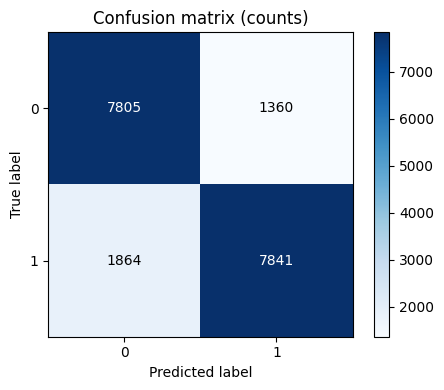

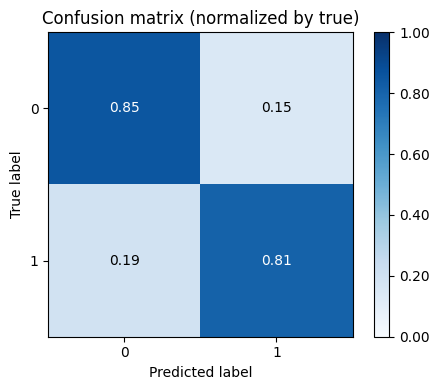

Best F1: 0.8378 at threshold 0.39999999999999997
Saved mlb_fast.joblib, svd_fast.joblib, xgb_fast.joblib and confusion matrices to ./figs/


In [39]:
import os, ast, joblib, numpy as np, pandas as pd
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import clone
from scipy import sparse
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

# -------- CONFIG --------
DATA_DIR = "/kaggle/input/drug-datasets"
POS = os.path.join(DATA_DIR, "pos.csv")
NEG = os.path.join(DATA_DIR, "neg.csv")
SIDE_EFFECTS = os.path.join(DATA_DIR, "Side_effects_unique.csv")
SAMPLE_SIZE = 50000  # per class
TOP_K = 300
SVD_DIM = 64
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_THREADS = -1
FP_DIM = 256
# ------------------------

os.makedirs("./figs", exist_ok=True)

# ---------- Load & Sample ----------
pos = pd.read_csv(POS, low_memory=False)
neg = pd.read_csv(NEG, low_memory=False)

pos['hyperedge_label'] = pos.get('hyperedge_label', 1).fillna(1).astype(int)
neg['hyperedge_label'] = neg.get('hyperedge_label', -1).fillna(-1).astype(int)

df_pos = pos[pos['hyperedge_label'] == 1].sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
df_neg = neg[neg['hyperedge_label'] == -1].sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
df = pd.concat([df_pos, df_neg], ignore_index=True).reset_index(drop=True)
df['label'] = (df['hyperedge_label'] == 1).astype(int)

print(f"Sampled data shape: {df.shape}, label dist: {df.label.value_counts().to_dict()}")

def parse_list_field(x):
    if isinstance(x, list): return [str(i).strip() for i in x if str(i).strip()]
    try:
        L = ast.literal_eval(x)
        if isinstance(L, list): return [str(i).strip() for i in L if str(i).strip()]
    except:
        s = str(x).strip().strip('[]')
        if not s: return []
        return [t.strip().strip("'\"") for t in s.split(',') if t.strip()]
    return []

df['drug_list'] = df['DrugBankID'].apply(parse_list_field)
df['drug_list'] = df['drug_list'].apply(lambda L: list(dict.fromkeys(L)))
df = df[df['drug_list'].apply(len) > 0].reset_index(drop=True)
df = df.drop_duplicates(subset=['report_id','SE_above_0.9','DrugBankID']).reset_index(drop=True)

# ---------- Hashed FP ----------
drug_fps = {}
unique_drugs = set(d for L in df['drug_list'] for d in L)
for d in unique_drugs:
    h = np.zeros(FP_DIM, dtype=np.float32)
    hash_val = abs(hash(d)) % FP_DIM
    h[hash_val] = 1.0
    drug_fps[d] = h

def mean_drug_fp(drug_list):
    fps = [drug_fps.get(d) for d in drug_list if d in drug_fps]
    if not fps:
        return np.zeros(FP_DIM, dtype=np.float32)
    return np.mean(fps, axis=0)

df['drug_fp_mean'] = [mean_drug_fp(L) for L in df['drug_list']]
print("Hashed FP done.")

# ---------- SE Embeddings ----------
se_df = pd.read_csv(SIDE_EFFECTS, low_memory=False)
se_embed_cols = [col for col in se_df.columns if col not in ['umls_cui_from_meddra', 'side_effect_name']]
print(f"SE embeds dims: {len(se_embed_cols)}")

se_embed_map = dict(zip(se_df['umls_cui_from_meddra'].astype(str), se_df[se_embed_cols].values))

default_embed = np.zeros(len(se_embed_cols), dtype=np.float32)
df['se_embed'] = [se_embed_map.get(se, default_embed) for se in df['SE_above_0.9'].astype(str)]

# ---------- Features ----------
all_drugs = [d for L in df['drug_list'] for d in L]
most_common = [d for d,_ in Counter(all_drugs).most_common(TOP_K)]
most_common_set = set(most_common)
df['drug_topk'] = df['drug_list'].apply(lambda L: [d for d in L if d in most_common_set])
df = df[df['drug_topk'].apply(len) > 0].reset_index(drop=True)

mlb = MultiLabelBinarizer(classes=most_common)
X_bag = mlb.fit_transform(df['drug_topk'])
X_bag_sp = sparse.csr_matrix(X_bag)

svd = TruncatedSVD(n_components=SVD_DIM, random_state=RANDOM_STATE)
X_svd = svd.fit_transform(X_bag_sp)

df['n_drugs'] = df['drug_topk'].apply(len)
df['possible_pairs'] = df['n_drugs'].apply(lambda n: max(1, n*(n-1)//2))
def time_to_float(t):
    try:
        y,q = str(t).split('Q'); return int(y) + (int(q)-1)/4.0
    except: return 0.0
df['time_num'] = df['time'].apply(time_to_float) if 'time' in df.columns else 0

num_feats = df[['n_drugs','possible_pairs','time_num']].fillna(0).values.astype(float)
X_fp = np.vstack(df['drug_fp_mean'].values)
se_embed_arr = np.vstack(df['se_embed'].values)

X_full_dense = np.hstack([X_svd, num_feats, X_fp, se_embed_arr])

print(f"Full feature shape: {X_full_dense.shape}")

# ---------- Split ----------
X_temp, X_test, y_temp, y_test = train_test_split(X_full_dense, df['label'], test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df['label'])
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)

print(f"Shapes -> train: {X_train.shape}, valid: {X_valid.shape}, test: {X_test.shape}")

classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
cw_map = {c:w for c,w in zip(classes, cw)}
sample_weight_train = np.array([cw_map[v] for v in y_train])

# ---------- XGB ----------
clf = XGBClassifier(
    objective='binary:logistic', eval_metric='auc', tree_method='hist',
    n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=0.1, random_state=RANDOM_STATE, n_jobs=N_THREADS,
    early_stopping_rounds=20
)

print("\nTraining XGB...")
clf.fit(X_train, y_train, sample_weight=sample_weight_train,
        eval_set=[(X_valid, y_valid)], verbose=20)

# Final fit: Disable early stopping
clf_no_es = clone(clf)
clf_no_es.early_stopping_rounds = None
X_trainplus = np.vstack([X_train, X_valid])
y_trainplus = np.concatenate([y_train, y_valid])
sw_trainplus = np.array([cw_map.get(v,1.0) for v in y_trainplus])
clf_no_es.fit(X_trainplus, y_trainplus, sample_weight=sw_trainplus)

final_model = clf_no_es

# ---------- Evaluate ----------
y_test_proba = final_model.predict_proba(X_test)[:,1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

print("\n📊 XGB Performance")
print("ROC-AUC:", round(roc_auc_score(y_test, y_test_proba), 4))
print("F1:", round(f1_score(y_test, y_test_pred), 4))
print(classification_report(y_test, y_test_pred))

# ---------- Confusion Matrix (counts + normalized) ----------
cm = confusion_matrix(y_test, y_test_pred)
# counts
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("Confusion matrix (counts)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0,1])
ax.set_yticks([0,1])
# annotate counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.colorbar(im, ax=ax)
plt.tight_layout()
fig.savefig("./figs/confusion_counts.png", dpi=150, bbox_inches='tight')
plt.show()

# normalized (by true labels)
cmn = confusion_matrix(y_test, y_test_pred, normalize='true')
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cmn, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
ax.set_title("Confusion matrix (normalized by true)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0,1])
ax.set_yticks([0,1])
# annotate floats
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(j, i, f"{cmn[i, j]:.2f}",
                ha="center", va="center",
                color="white" if cmn[i, j] > 0.5 else "black")
plt.colorbar(im, ax=ax, format=plt.FuncFormatter(lambda x, _: f"{x:.2f}"))
plt.tight_layout()
fig.savefig("./figs/confusion_normalized.png", dpi=150, bbox_inches='tight')
plt.show()

# Threshold tuning
thresholds = np.arange(0.3, 0.7, 0.05)
best_f1, best_thresh = 0, 0.5
for thresh in thresholds:
    pred_thresh = (y_test_proba >= thresh).astype(int)
    f1 = f1_score(y_test, pred_thresh)
    if f1 > best_f1:
        best_f1, best_thresh = f1, thresh
print(f"Best F1: {round(best_f1, 4)} at threshold {best_thresh}")

# ---------- Save ----------
joblib.dump(mlb, "mlb_fast.joblib")
joblib.dump(svd, "svd_fast.joblib")
joblib.dump(final_model, "xgb_fast.joblib")

print("Saved mlb_fast.joblib, svd_fast.joblib, xgb_fast.joblib and confusion matrices to ./figs/")


In [23]:
import numpy as np

# Precompute hashed FP for Top-K drugs (from training)
FP_DIM = 256
drug_fps = {d: np.zeros(FP_DIM, dtype=np.float32) for d in mlb.classes_}
for d in mlb.classes_:
    h = np.zeros(FP_DIM, dtype=np.float32)
    h[abs(hash(d)) % FP_DIM] = 1.0
    drug_fps[d] = h

# Load SE embeddings map (from training)
se_embed_map = dict(zip(se_df["umls_cui_from_meddra"].astype(str),
                        se_df[[c for c in se_df.columns if c not in ['umls_cui_from_meddra','side_effect_name']]].values))
default_embed = np.zeros(len(next(iter(se_embed_map.values()))), dtype=np.float32)

def mean_drug_fp(drug_list):
    fps = [drug_fps.get(d, np.zeros(FP_DIM, dtype=np.float32)) for d in drug_list]
    if not fps:
        return np.zeros(FP_DIM, dtype=np.float32)
    return np.mean(fps, axis=0)

def predict_with_names_full(drug_list, se_code=None, threshold=0.6):
    # Filter known drugs
    known_ids = [d for d in drug_list if d in mlb.classes_]
    known_names = [id_to_name(d) for d in known_ids]
    
    # 1️⃣ Top-K drug bag
    Xb = mlb.transform([known_ids])
    Xs = svd.transform(Xb)
    
    # 2️⃣ Numeric features
    n_drugs = len(known_ids)
    X_num = np.array([[n_drugs, max(1, n_drugs*(n_drugs-1)//2), 0.0]])
    
    # 3️⃣ Hashed FP
    X_fp = mean_drug_fp(known_ids).reshape(1,-1)
    
    # 4️⃣ SE embedding
    se_embed = se_embed_map.get(se_code, default_embed).reshape(1,-1)
    
    # Combine all features
    Xf = np.hstack([Xs, X_num, X_fp, se_embed])
    
    # Predict
    prob = float(model.predict_proba(Xf)[:,1])
    label = "HIGH RISK" if prob >= threshold else "LOW RISK"
    
    return {
        "drugbank_ids": known_ids,
        "drug_names": known_names,
        "n_drugs": n_drugs,
        "probability": round(prob, 3),
        "label": label,
        "side_effect_code": se_code,
        "side_effect_name": se_to_label(se_code)
    }

# ✅ Test example
example = predict_with_names_full(["DB01050","DB00555","DB00472"], "C0151878")
print(example)


{'drugbank_ids': ['DB01050', 'DB00555', 'DB00472'], 'drug_names': ['Ibuprofen', 'Lamotrigine', 'Fluoxetine'], 'n_drugs': 3, 'probability': 0.946, 'label': 'HIGH RISK', 'side_effect_code': 'C0151878', 'side_effect_name': 'Electrocardiogram QT prolonged'}


In [22]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from scipy import sparse
from collections import Counter

# ---------- Load model and encoders ----------
mlb = joblib.load("mlb_fast.joblib")
svd = joblib.load("svd_fast.joblib")
model = joblib.load("xgb_fast.joblib")

# ---------- Load full dataset ----------
DATA_DIR = "/kaggle/input/drug-datasets"
POS = f"{DATA_DIR}/pos.csv"
NEG = f"{DATA_DIR}/neg.csv"
SIDE_EFFECTS = f"{DATA_DIR}/Side_effects_unique.csv"

pos = pd.read_csv(POS, low_memory=False)
neg = pd.read_csv(NEG, low_memory=False)

pos['hyperedge_label'] = pos.get('hyperedge_label', 1).fillna(1).astype(int)
neg['hyperedge_label'] = neg.get('hyperedge_label', -1).fillna(-1).astype(int)

df = pd.concat([pos, neg], ignore_index=True)
df['label'] = (df['hyperedge_label'] == 1).astype(int)

def parse_list_field(x):
    try:
        L = eval(x)
        return [str(i).strip() for i in L if str(i).strip()]
    except:
        s = str(x).strip('[]')
        return [i.strip().strip("'\"") for i in s.split(',') if i.strip()]

df['drug_list'] = df['DrugBankID'].apply(parse_list_field)
df['drug_list'] = df['drug_list'].apply(lambda L: list(dict.fromkeys(L)))
df = df[df['drug_list'].apply(len) > 0].reset_index(drop=True)

# ---------- Feature preparation ----------
TOP_K = 300
all_drugs = [d for L in df['drug_list'] for d in L]
most_common = [d for d,_ in Counter(all_drugs).most_common(TOP_K)]
most_common_set = set(most_common)
df['drug_topk'] = df['drug_list'].apply(lambda L: [d for d in L if d in most_common_set])
df = df[df['drug_topk'].apply(len) > 0].reset_index(drop=True)

# Numeric features
df['n_drugs'] = df['drug_topk'].apply(len)
df['possible_pairs'] = df['n_drugs'].apply(lambda n: max(1, n*(n-1)//2))
df['time_num'] = 0.0  # match training

# Hashed FP
FP_DIM = 256
drug_fps = {d:np.eye(1,FP_DIM,k=abs(hash(d))%FP_DIM,dtype=np.float32).flatten() for d in most_common}
def mean_drug_fp(L):
    fps = [drug_fps.get(d,np.zeros(FP_DIM,dtype=np.float32)) for d in L]
    return np.mean(fps, axis=0)
df['drug_fp_mean'] = [mean_drug_fp(L) for L in df['drug_list']]

# SE embeddings
se_df = pd.read_csv(SIDE_EFFECTS, low_memory=False)
se_embed_cols = [c for c in se_df.columns if c not in ['umls_cui_from_meddra','side_effect_name']]
se_embed_map = dict(zip(se_df['umls_cui_from_meddra'].astype(str), se_df[se_embed_cols].values))
default_embed = np.zeros(len(se_embed_cols),dtype=np.float32)
df['se_embed'] = [se_embed_map.get(se,default_embed) for se in df['SE_above_0.9'].astype(str)]

# Full feature matrix
X_bag = mlb.transform(df['drug_topk'])
X_svd = svd.transform(X_bag)
num_feats = df[['n_drugs','possible_pairs','time_num']].values.astype(float)
X_fp = np.vstack(df['drug_fp_mean'].values)
se_embed_arr = np.vstack(df['se_embed'].values)
X_full = np.hstack([X_svd,num_feats,X_fp,se_embed_arr])
y_full = df['label'].values

# ---------- Split for test ----------
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# ---------- Evaluate ----------
y_proba = model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print("📊 Test Set Performance")
print(f"ROC-AUC: {auc:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: tune threshold for best F1
thresholds = np.arange(0.3,0.7,0.05)
best_f1, best_thresh = 0, 0.5
for t in thresholds:
    tmp_pred = (y_proba >= t).astype(int)
    f = f1_score(y_test, tmp_pred)
    if f > best_f1:
        best_f1, best_thresh = f, t
print(f"\nBest F1: {best_f1:.4f} at threshold {best_thresh:.2f}")


📊 Test Set Performance
ROC-AUC: 0.9099
F1-Score: 0.8368

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     20336
           1       0.86      0.82      0.84     21538

    accuracy                           0.84     41874
   macro avg       0.84      0.84      0.84     41874
weighted avg       0.84      0.84      0.84     41874


Best F1: 0.8428 at threshold 0.40


Eval sets logged: ['validation_0']


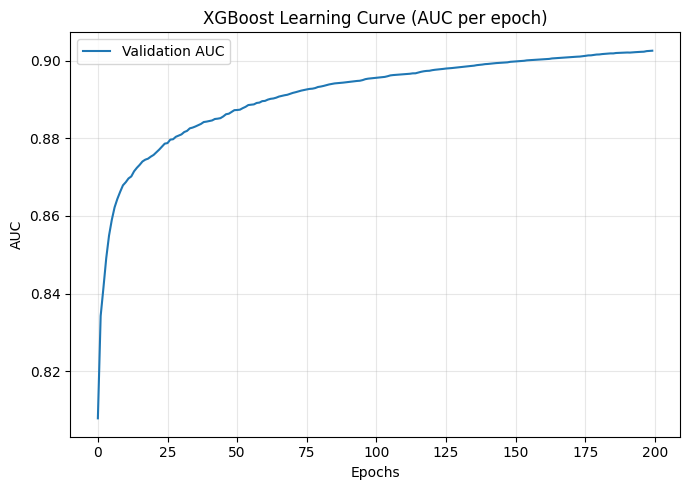

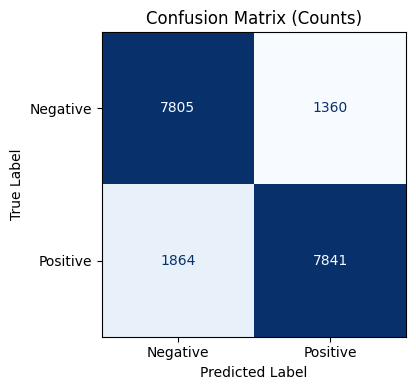

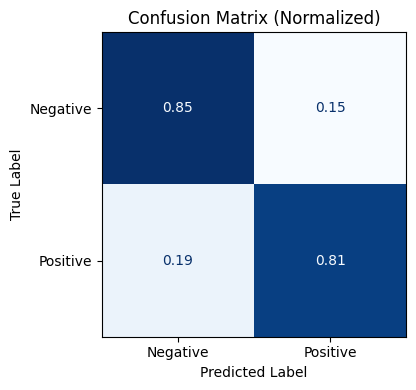

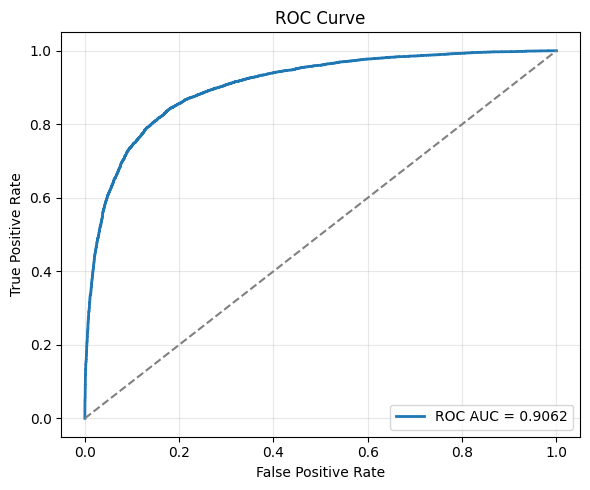

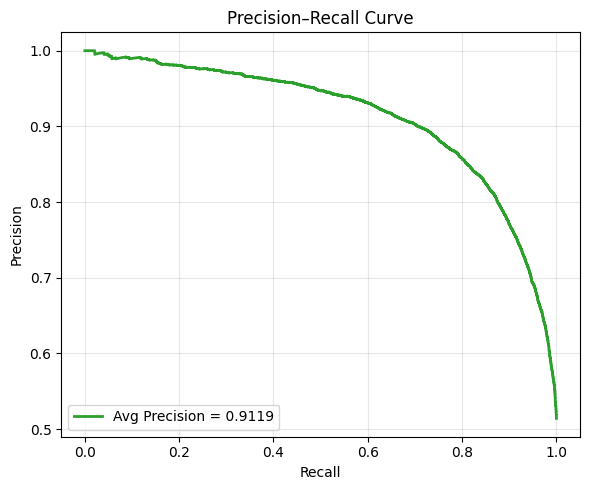

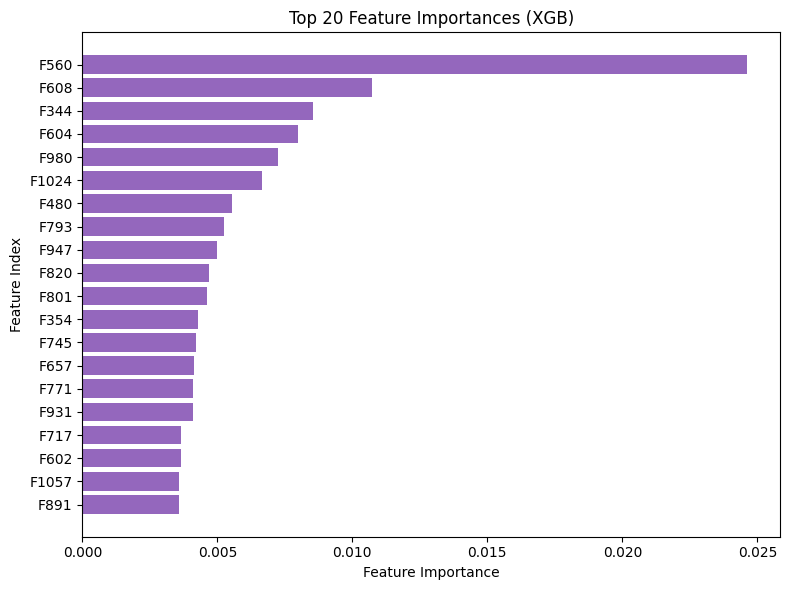

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve,
    precision_recall_curve, average_precision_score
)
import numpy as np

# ---------------- Learning Curve (AUC vs Epochs) ----------------
results = clf.evals_result()
print("Eval sets logged:", list(results.keys()))

plt.figure(figsize=(7,5))
plt.plot(results['validation_0']['auc'], label='Validation AUC', color='tab:blue')
if 'train' in results:
    plt.plot(results['train']['auc'], label='Train AUC', color='tab:orange')
elif 'validation_1' in results:
    plt.plot(results['validation_1']['auc'], label='Train AUC', color='tab:orange')
plt.title('XGBoost Learning Curve (AUC per epoch)')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(values_format='d', cmap='Blues', ax=ax, colorbar=False)
ax.set_title("Confusion Matrix (Counts)")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.tight_layout()
plt.show()

# Normalized version
cm_norm = confusion_matrix(y_test, y_test_pred, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Negative', 'Positive'])
fig, ax = plt.subplots(figsize=(5,4))
disp_norm.plot(values_format='.2f', cmap='Blues', ax=ax, colorbar=False)
ax.set_title("Confusion Matrix (Normalized)")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.tight_layout()
plt.show()

# ---------------- ROC Curve ----------------
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, color='tab:blue', label=f"ROC AUC = {roc_auc_score(y_test, y_test_proba):.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------- Precision–Recall Curve ----------------
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ap = average_precision_score(y_test, y_test_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, lw=2, color='tab:green', label=f"Avg Precision = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------- Feature Importance ----------------
plt.figure(figsize=(8,6))
importance = final_model.feature_importances_
indices = np.argsort(importance)[-20:]  # top 20
plt.barh(range(len(indices)), importance[indices], color='tab:purple', align='center')
plt.yticks(range(len(indices)), [f"F{i}" for i in indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Index")
plt.title("Top 20 Feature Importances (XGB)")
plt.tight_layout()
plt.show()


In [46]:
import random

# Ensure you have df aligned with X_full_dense splits
# Note: train_test_split shuffles rows, so you must use the same indices for df_test
_, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df['label'])

# Define helper mappings if available
# If your DrugBankID → Name mapping or SE → Label mapping is not available,
# these fallback functions will show IDs directly.

def id_to_name(drug_id):
    # Example lookup using DrugBank mapping file if available
    # Modify this if you have a 'drug_map.csv' or similar file
    return str(drug_id)  # fallback (just return ID)

def se_to_label(se_id):
    # Example lookup from se_df (Side_effects_unique.csv)
    try:
        return se_df.loc[se_df['umls_cui_from_meddra'].astype(str) == str(se_id), 'side_effect_name'].values[0]
    except:
        return str(se_id)

# Pick N random indices from test set
N = 5
random_indices = random.sample(range(X_test.shape[0]), N)

print(f"\n🔍 Inspecting {N} random test samples:\n")
for i, idx in enumerate(random_indices, 1):
    row_features = X_test[idx].reshape(1, -1)
    true_label = y_test.iloc[idx] if isinstance(y_test, pd.Series) else y_test[idx]
    
    prob = float(final_model.predict_proba(row_features)[:,1])
    pred_label = int(prob >= 0.5)
    
    # Get corresponding row from df_test
    drug_list = df_test.iloc[idx]['drug_list']
    se_code = df_test.iloc[idx]['SE_above_0.9']
    se_name = se_to_label(se_code)
    drug_names = [id_to_name(d) for d in drug_list]
    
    print(f"🧪 Sample {i}:")
    print(f"  📦 Drugs (IDs): {drug_list}")
    print(f"  💊 Drugs (Names): {drug_names}")
    print(f"  ⚠️ Side effect code: {se_code}")
    print(f"  ⚕️ Side effect name: {se_name}")
    print(f"  ✅ True label: {true_label}")
    print(f"  🤖 Predicted probability: {prob:.4f}")
    print(f"  📈 Predicted label: {pred_label}")
    print("-" * 80)



🔍 Inspecting 5 random test samples:

🧪 Sample 1:
  📦 Drugs (IDs): ['DB16637', 'DB03439', 'DB00451', 'DB00563', 'DB00169', 'DB00338', 'DB13919', 'DB00528']
  💊 Drugs (Names): ['DB16637', 'DB03439', 'DB00451', 'DB00563', 'DB00169', 'DB00338', 'DB13919', 'DB00528']
  ⚠️ Side effect code: C0005558
  ⚕️ Side effect name: biopsy
  ✅ True label: 0
  🤖 Predicted probability: 0.3314
  📈 Predicted label: 0
--------------------------------------------------------------------------------
🧪 Sample 2:
  📦 Drugs (IDs): ['DB15565', 'DB00656']
  💊 Drugs (Names): ['DB15565', 'DB00656']
  ⚠️ Side effect code: C0186666
  ⚕️ Side effect name: rotator cuff repair
  ✅ True label: 0
  🤖 Predicted probability: 0.0627
  📈 Predicted label: 0
--------------------------------------------------------------------------------
🧪 Sample 3:
  📦 Drugs (IDs): ['DB00537', 'DB00476']
  💊 Drugs (Names): ['DB00537', 'DB00476']
  ⚠️ Side effect code: C0006325
  ⚕️ Side effect name: Bruxism
  ✅ True label: 1
  🤖 Predicted prob